In [ ]:
# split the data into train, val and test folders
import pandas as pd
import os
import shutil
from sklearn.model_selection import train_test_split
from tqdm import tqdm


# Read the CSV file and shuffle the rows
df = pd.read_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df.csv').sample(frac=1).reset_index(drop=True)
# Create a new column of filename
df['filename'] = df['image_path'].apply(lambda x: os.path.basename(x))
# save the df
df.to_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df_new.csv', index=False)

source_folder_path = '/mnt/g/Datasets/Body_Parts_XRay/images/train/'
dest_folder_path = '/mnt/g/Datasets/Body_Parts_XRay/Original/'

# Split the data
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Define a function to copy files
def copy_files(df, dest_folder):
    for index, row in df.iterrows():
        filename = row['filename']
        src_file = os.path.join(source_folder_path, filename)
        dest_file = os.path.join(dest_folder_path, dest_folder, 'images',filename)
        shutil.copy(src_file, dest_file)

# Copy files to their respective folders
copy_files(train_df, 'train')
copy_files(val_df, 'val')
copy_files(test_df, 'test')

In [5]:
from PIL import Image
import numpy as np
source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/train/images/1.2.826.0.1.3680043.8.498.10038426859954986240523417641213777162-c.png'
img = Image.open(source_folder)
img = np.array(img)
print(img)

[[200 201 202 ...  27  27  27]
 [199 200 201 ...  26  27  27]
 [203 202 202 ...  26  27  27]
 ...
 [ 27  27  27 ...  17   0   1]
 [ 26  27  27 ...  35   0   0]
 [ 27  27  26 ...  50   8   0]]


In [6]:
# Remove 4 black regions at all 4 edges. Add black padding to make it square
from PIL import Image
import os

def remove_dark_edges(source_folder, destination_folder):
    """Remove dark edges from the image."""

    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    def remove_dark_edges(img):
        """Remove dark edges from the image."""
        data = img.load()
        width, height = img.size
        
        left, right = 0, width
        top, bottom = 0, height
        
        def is_dark(pixel):
            if isinstance(pixel, int):
                return pixel < 5
            return pixel < (5, 5, 5)
        
        # Check left edge
        for x in range(width):
            if not is_dark(data[x, height // 2]):
                left = x
                break
                
        # Check right edge
        for x in range(width - 1, -1, -1):
            if not is_dark(data[x, height // 2]):
                right = x + 1
                break
                
        # Check top edge
        for y in range(height):
            if not is_dark(data[width // 2, y]):
                top = y
                break
                
        # Check bottom edge
        for y in range(height - 1, -1, -1):
            if not is_dark(data[width // 2, y]):
                bottom = y + 1
                break
                
        return img.crop((left, top, right, bottom))

    def add_black_padding(img):
        """Add black padding to make the image square."""
        width, height = img.size
        size = max(width, height)
        
        new_img = Image.new("RGB", (size, size), color=(0, 0, 0))
        new_img.paste(img, ((size - width) // 2, (size - height) // 2))
        
        return new_img

    for image_file in os.listdir(source_folder):
        if image_file.endswith('.png'):
            img_path = os.path.join(source_folder, image_file)
            img = Image.open(img_path)
            
            img = remove_dark_edges(img)
            if img.width != img.height:
                img = add_black_padding(img)
                
            img.save(os.path.join(destination_folder, image_file))


source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/train/images'
destination_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/images'
remove_dark_edges(source_folder, destination_folder)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/val/images'
destination_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/val/images'
remove_dark_edges(source_folder, destination_folder)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/test/images'
destination_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/test/images'
remove_dark_edges(source_folder, destination_folder)

In [ ]:
source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/test/images/'
image_files = [f for f in os.listdir(source_folder) if f.endswith('.png')]
print(image_files[:5])

In [74]:
#Calculate the mean and standard deviation of the dataset

from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, ToTensor, Compose
from torch.utils.data import DataLoader

dataset_path = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/'

# Define the transform
transform = Compose([
    Resize((512, 512)),  # Resize all images to 512x512
    ToTensor()
])

# Create the dataset with the transform
dataset = ImageFolder(root=dataset_path, transform=transform)

# Create the DataLoader with the transformed dataset
dataloader = DataLoader(dataset, batch_size=64, shuffle=False, num_workers=0)

# Compute the mean and standard deviation
mean = 0.
std = 0.
for images, _ in dataloader:
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(dataloader.dataset)
std /= len(dataloader.dataset)

print(mean, std) #tensor([0.4233, 0.4233, 0.4233]) tensor([0.2114, 0.2114, 0.2114])


tensor([0.3453, 0.3453, 0.3453]) tensor([0.2566, 0.2566, 0.2566])


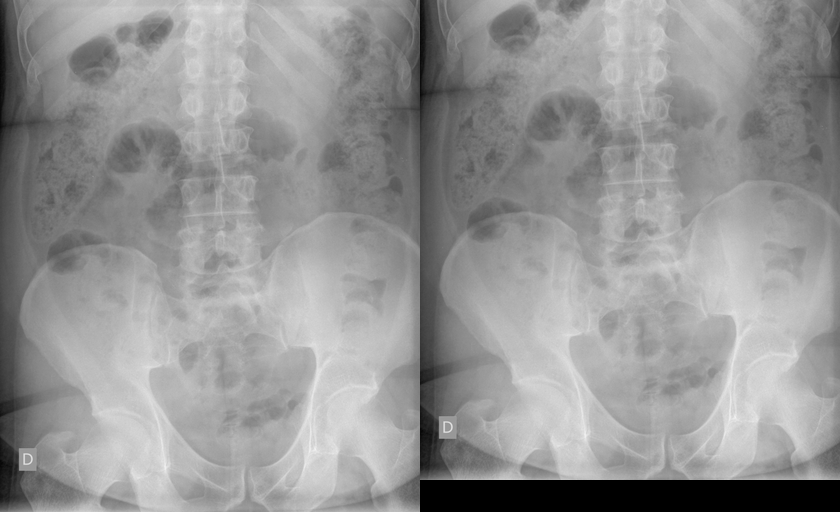

In [73]:
from PIL import Image
import random

# def random_resize_and_crop(image_path):
#     # Open the original image
#     original_image = Image.open(image_path)
#     original_width, original_height = original_image.size
    
#     # Calculate new dimensions
#     new_width = int(original_width * random.uniform(0.9, 1.1))
#     new_height = int(original_height * random.uniform(0.9, 1.9))
    
#     # Resize the image
#     resized_image = original_image.resize((new_width, new_height), Image.BICUBIC)
    
#     # Randomly select the starting x-coordinate for cropping
#     max_x = max(0, new_width - original_width)
#     x_offset = random.randint(0, max_x)
    
#     # Calculate the y-coordinate to ensure the bottom edge is preserved
#     y_offset = new_height - original_height
    
#     # Crop the image (new_height guarantees that the bottom edge is preserved)
#     cropped_image = resized_image.crop((x_offset, y_offset, x_offset + original_width, new_height))
    
#     return cropped_image

from PIL import ImageOps

def random_padding_and_crop(image_path):
    # Load the image
    image = Image.open(image_path)
    original_width, original_height = image.size
    
    # Determine padding values
    left_padding = int(random.uniform(0, 0.1 * original_width))
    right_padding = int(random.uniform(0, 0.1 * original_width))
    top_padding = int(random.uniform(0, 0.1 * original_height))
    bottom_padding = int(random.uniform(0, 0.1 * original_height))
    
    # Apply padding to the image
    padded_image = ImageOps.expand(image, (left_padding, top_padding, right_padding, bottom_padding))
    
    # Calculate the cropping box while ensuring the bottom edge of the original image is kept
    left = random.randint(0, left_padding+right_padding)
    right = left + original_width
    lower = random.randint(original_height+top_padding, original_height+top_padding+bottom_padding)
    upper = lower - original_height

    # Crop the image
    cropped_image = padded_image.crop((left, upper, right, lower))
    return cropped_image

# Example usage:
image_path = '/mnt/g/Datasets/Body_Parts_XRay/Original/test/images/1.2.826.0.1.3680043.8.498.10107388868056003719871837223999138217-c.png'
original_image = Image.open(image_path)
resulting_image = random_padding_and_crop(image_path)

# Concatenate and display images side by side
concatenated_image = Image.new('RGB', (2 * original_image.width, original_image.height))
concatenated_image.paste(original_image, (0, 0))
concatenated_image.paste(resulting_image, (original_image.width, 0))
concatenated_image.show()

In [22]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision.transforms import functional as F
from torchvision.transforms import (Normalize, Compose, RandomResizedCrop, RandomRotation, 
                                   RandomHorizontalFlip, ColorJitter, RandomAffine, 
                                   GaussianBlur, RandomCrop, RandomErasing, InterpolationMode, 
                                   ToTensor, Resize, CenterCrop, Lambda)
import random, torch


class AlbumentationsTransform:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, img):
        img = F.to_tensor(img).numpy() * 255  # Convert to numpy array in range [0, 255]
        img = img.transpose(1, 2, 0)  # Convert from CxHxW to HxWxC
        img = self.transform(image=img)['image']
        img = F.to_pil_image(img.astype('uint8'))  # Convert back to PIL image
        return img


class AlbumentationsTransform2:
    def __init__(self, transform=None):
        self.transform = transform

    def __call__(self, img):
        img = np.array(img)  # Convert to numpy array
        img = self.transform(image=img)['image']
        return Image.fromarray(img)  # Convert back to PIL image


class RandomAugmentation:
    def __init__(self, probability, *transforms):
        self.probability = probability
        self.transforms = transforms

    def __call__(self, img):
        if random.random() <= self.probability:
            for transform in self.transforms:
                img = transform(img)
        return img

# Define the CLAHE transformation
clahe = A.CLAHE(p=1.0, clip_limit=4.0, tile_grid_size=(8, 8))

# Define the mean and standard deviation of the dataset
MEAN = (0.3942, 0.3942, 0.3942)#(0.48145466, 0.4578275, 0.40821073)
STD = (0.2378, 0.2378, 0.2378)#(0.26862954, 0.26130258, 0.27577711)
image_size = (224,224)

def _convert_to_rgb(image):
    return image.convert('RGB')

# Albumentations transformations
albu_transforms = A.Compose([
    # A.ElasticTransform(p=0.5, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03),  # Elastic deformation
    # A.HistogramMatching(p=0.5, reference_images=None),  # Histogram Equalization (note: you need reference images)
    # Add any other albumentations transforms here
    A.GaussianBlur(p=0.3, blur_limit=(3, 5))
])

# torchvision transforms
pre_rotation = Compose([
    RandomRotation(degrees=15),
])

pre_resize = Compose([
    RandomResizedCrop(
        image_size,
        scale=(0.9, 1.1),
        interpolation=InterpolationMode.BICUBIC,
    ),
])

pre_transforms = Compose([
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.15, contrast=0.15),
    RandomAffine(degrees=0, translate=(0.1, 0.1)),
    RandomCrop(size=image_size, padding=10),
    # GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
])

post_transforms = Compose([
    _convert_to_rgb,
    ToTensor(),
    RandomErasing(p=0.2, scale=(0.01, 0.1), ratio=(0.3, 3.3), value=0, inplace=False),  # Cutout or Random Erasing
])

train_transform = Compose([
    AlbumentationsTransform2(clahe),
    RandomAugmentation(0.3, pre_rotation),
    pre_resize,
    # 0.3 means 30% of images will be augmented
    RandomAugmentation(0.3, pre_transforms, AlbumentationsTransform(albu_transforms)),
    # AlbumentationsTransform2(clahe),
    post_transforms
])

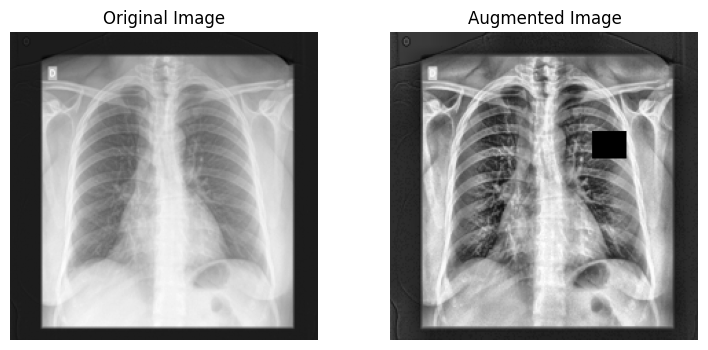

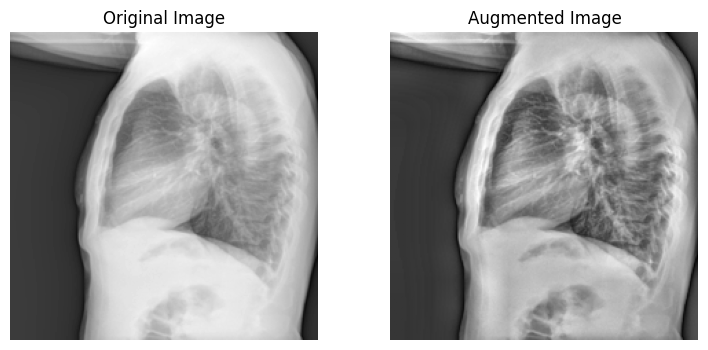

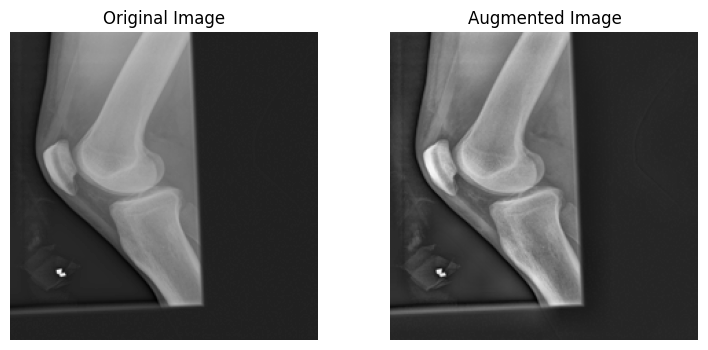

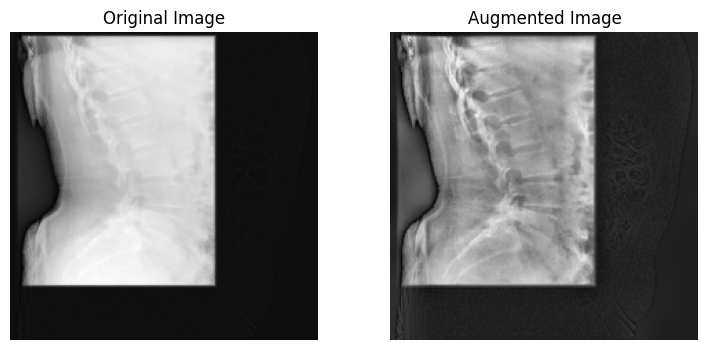

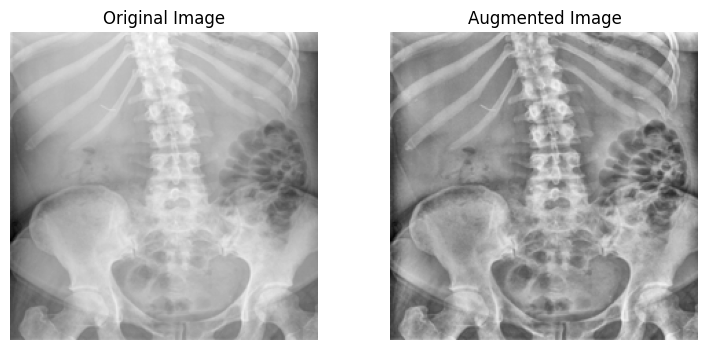

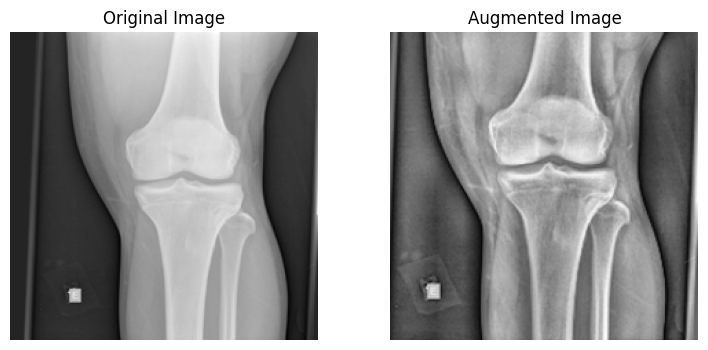

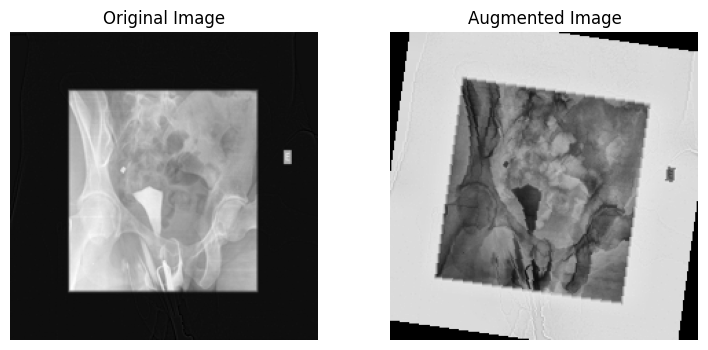

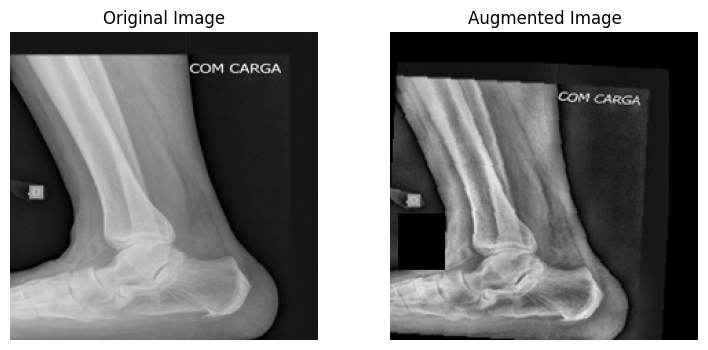

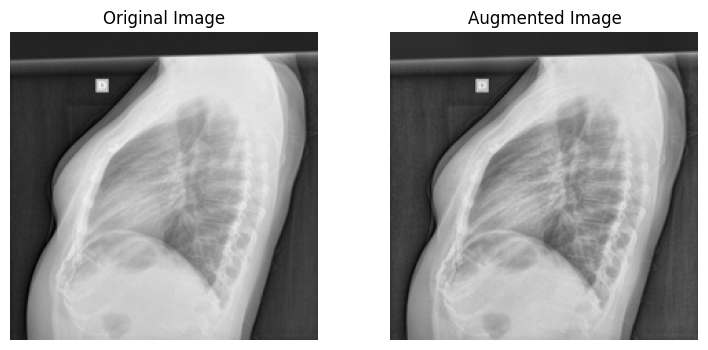

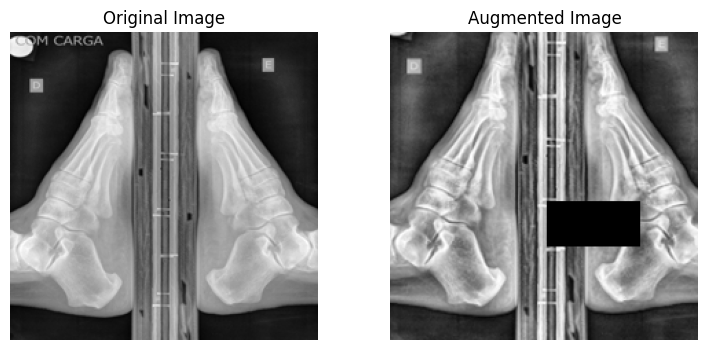

In [3]:
"""
To visualize the augmentation on a few images, you can follow the steps below:

Load a few images.
Apply the transformation pipeline train_transform to each image.
Display the original and augmented images side by side using matplotlib.

Remember to change path_to_your_images to the directory where your images are located. 
The code will display the original and augmented images side by side for the first five images in the directory. 
This will allow you to inspect the effects of your augmentation pipeline.
"""
import os, random
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
from torchvision.transforms import ToPILImage
import sys
sys.path.append('/home/yilu/Development/open_clip/Body_Parts_XRay/')
from image_augmentation import customized_augmentation

image_size = (224,224)
train_transform = customized_augmentation(image_size)

to_pil = ToPILImage()

def visualize_augmentations(original_img, augmented_img):
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    ax[0].imshow(original_img, cmap="gray") #
    ax[0].set_title("Original Image")
    ax[1].imshow(augmented_img, cmap="gray")
    ax[1].set_title("Augmented Image")
    for a in ax:
        a.axis("off")
    plt.show()


# Load a few images
# image_folder = '/mnt/eds_share/share/Body_Parts_XRay/images/train/'
image_folder = '/mnt/g/Datasets/Body_Parts_XRay/Original/test/images/'
sample_images = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)]
sample_images = random.sample(sample_images, 10)

for image_path in sample_images:
    original_img = Image.open(image_path).resize(image_size)
    # print(np.array(original_img).shape, np.array(original_img).max()/255., np.array(original_img).min()/255.)
    augmented_img = train_transform(original_img)
    # print(np.array(augmented_img).shape, np.array(augmented_img).max(), np.array(augmented_img).min())
    augmented_img = augmented_img.permute(1, 2, 0)  # Convert CxHxW to HxWxC for visualization
    # print(augmented_img.shape)
    
    #histogram for original image
    image = original_img.convert('L')
    # Convert the image to a numpy array
    histogram_original = np.array(image).ravel()
    
    # #histogram for augmented image
    # augmented_img_permuted = augmented_img.permute(2, 0, 1)
    # augmented_img_pil = to_pil(augmented_img_permuted)
    # augmented_img_gray = augmented_img_pil.convert('L')
    # # Convert the image to a numpy array
    # histogram_augmented = np.array(augmented_img_gray).ravel()
    
    # visualize_augmentations(original_img, augmented_img, histogram_original, histogram_augmented)
    visualize_augmentations(original_img, augmented_img)
    

"\nThe AlbumentationsTransform class acts as a bridge between torchvision and albumentations.\nThe HistogramMatching transformation in albumentations requires a set of reference images to match the histogram. You'd need to specify that.\nAlways ensure that ToTensor() is one of the last transformations, because it changes the data type and order of dimensions.\nTest the transformation pipeline on a few images to ensure it's working as expected.\n"

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


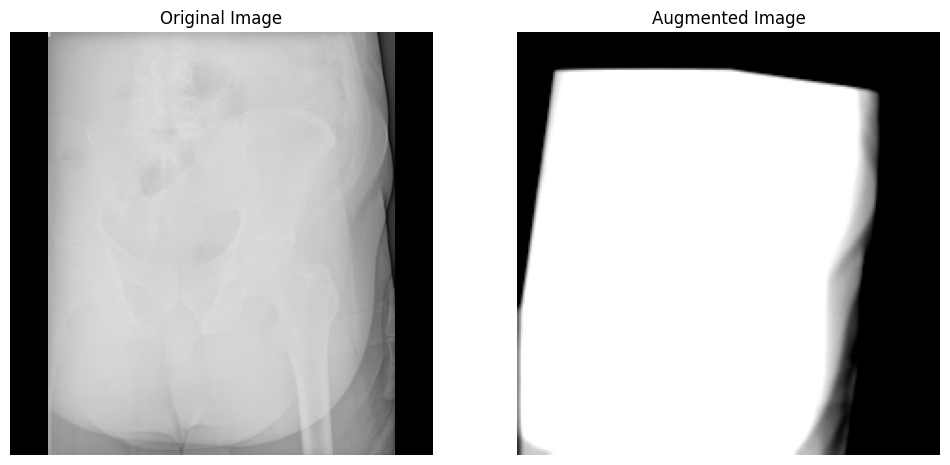

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


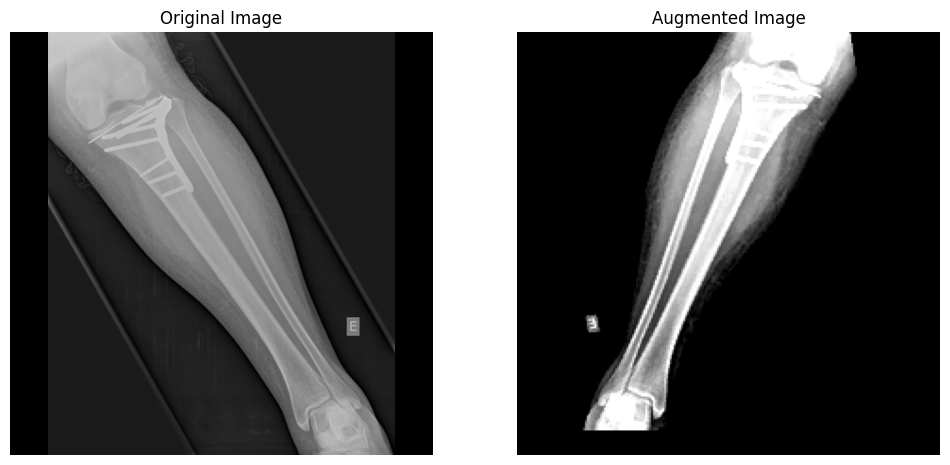

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


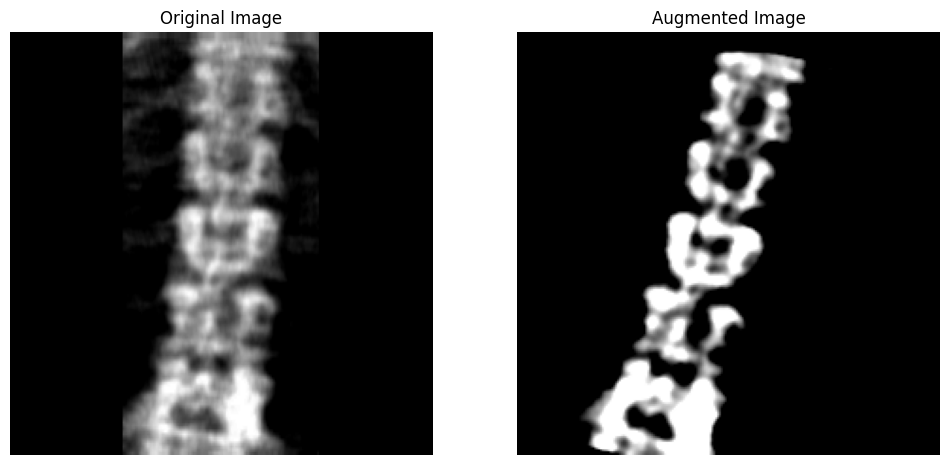

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


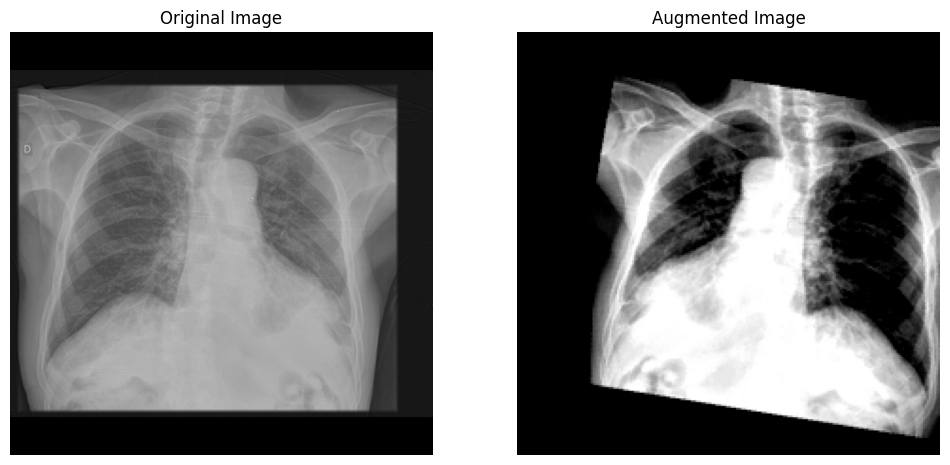

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


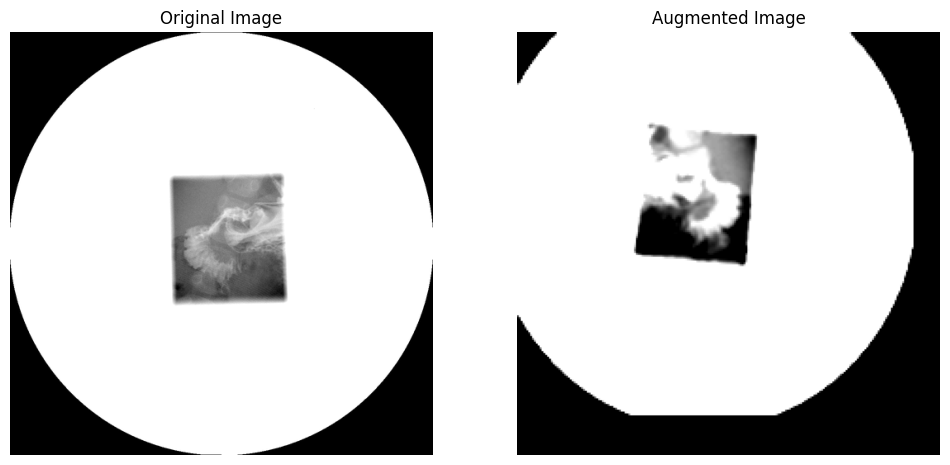

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


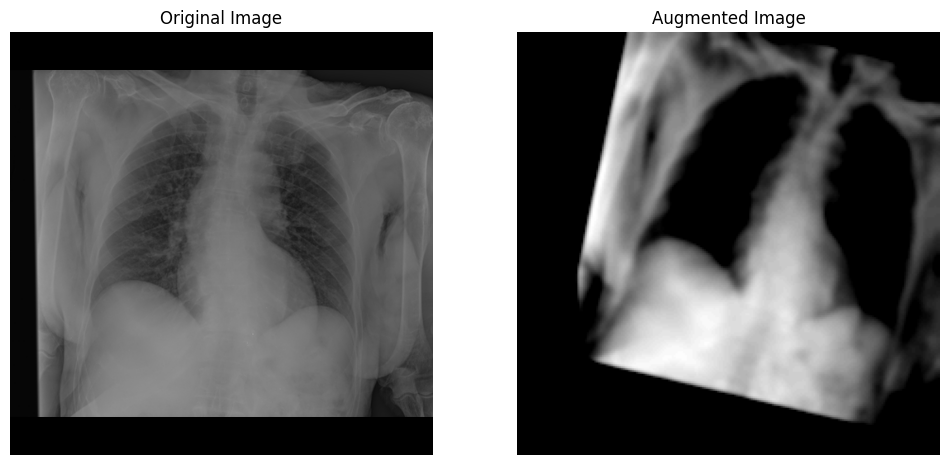

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


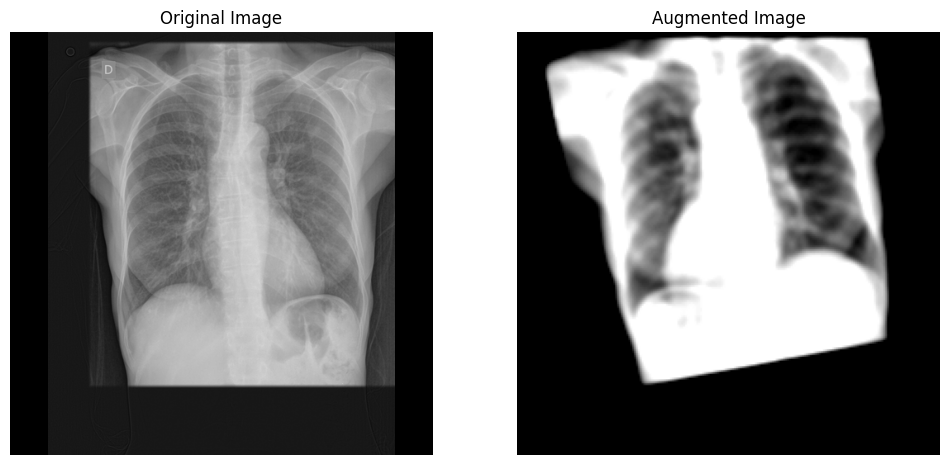

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


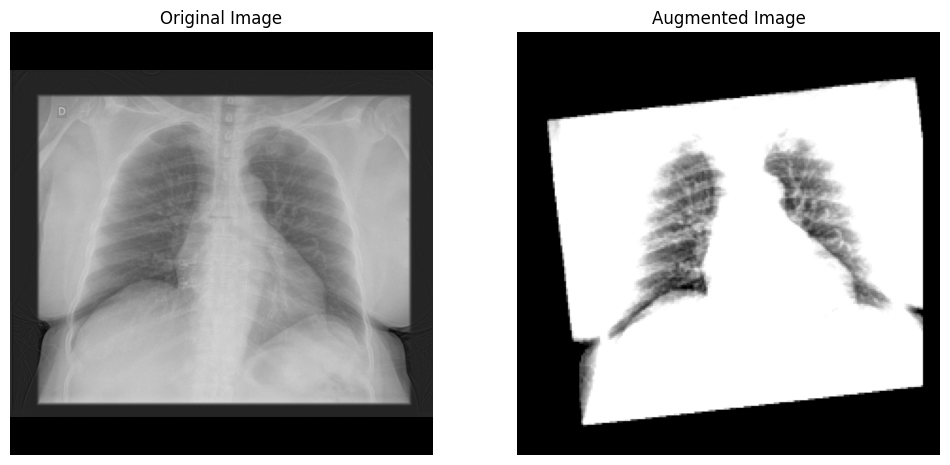

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


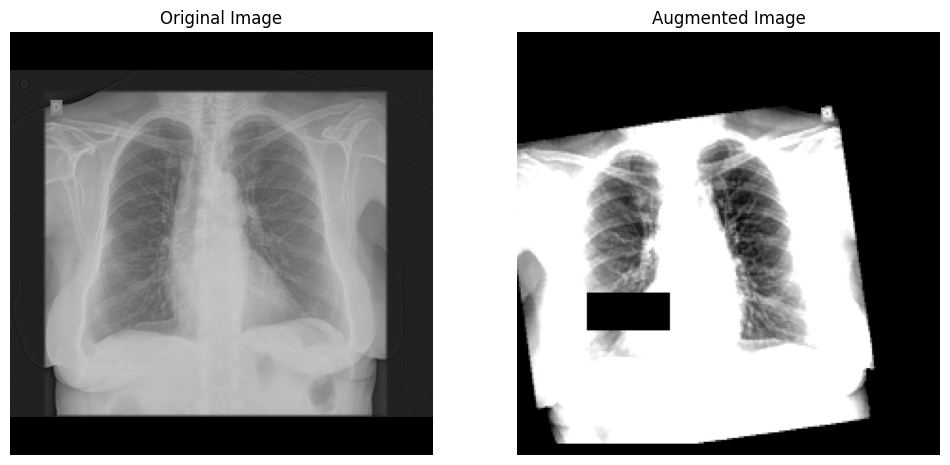

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


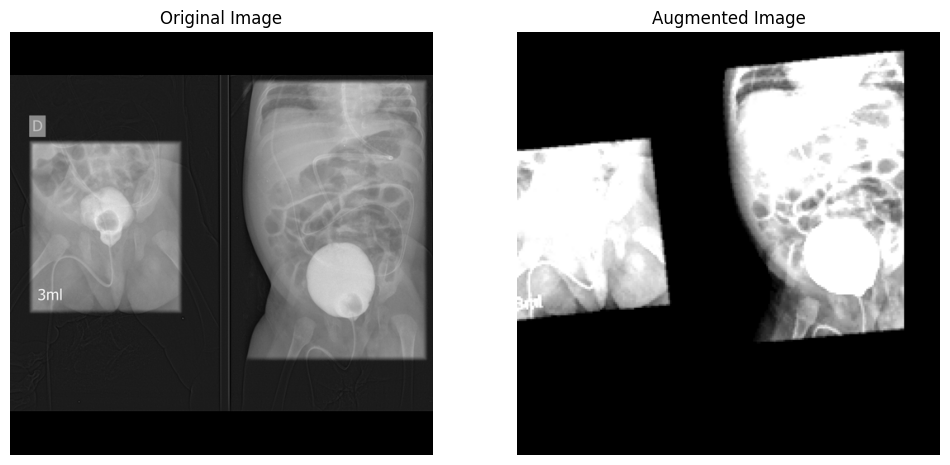

In [114]:
"""
To visualize the augmentation on a few images, you can follow the steps below:

Load a few images.
Apply the transformation pipeline train_transform to each image.
Display the original and augmented images side by side using matplotlib.

Remember to change path_to_your_images to the directory where your images are located. 
The code will display the original and augmented images side by side for the first five images in the directory. 
This will allow you to inspect the effects of your augmentation pipeline.
"""
import os
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd

def visualize_augmentations(original_img, augmented_img):
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(original_img, cmap="gray") #
    ax[0].set_title("Original Image")
    ax[1].imshow(augmented_img, cmap="gray")
    ax[1].set_title("Augmented Image")
    for a in ax:
        a.axis("off")
    plt.show()

# Load a few images
image_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/images'  # Change this to your image directory
sample_images = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)[:10]]

for image_path in sample_images:
    original_img = Image.open(image_path)
    augmented_img = train_transform(original_img)
    augmented_img = augmented_img.permute(1, 2, 0)  # Convert CxHxW to HxWxC for visualization
    visualize_augmentations(original_img, augmented_img)


In [10]:
# generate captions.txt for image folder
import pandas as pd
import os
# Dictionary to map integers to tissue types
tissue_map = {
    0: "Abdomen",
    1: "Ankle",
    2: "Cervical Spine",
    3: "Chest",
    4: "Clavicles",
    5: "Elbow",
    6: "Feet",
    7: "Finger",
    8: "Forearm",
    9: "Hand",
    10: "Hip",
    11: "Knee",
    12: "Lower Leg",
    13: "Lumbar Spine",
    14: "Others",
    15: "Pelvis",
    16: "Shoulder",
    17: "Sinus",
    18: "Skull",
    19: "Thigh",
    20: "Thoracic Spine",
    21: "Wrist"
}

def generate_caption (source_folder, output_file):
    # List all jpg images in the source folder
    image_files = [f for f in os.listdir(source_folder) if f.endswith('.png')]

    # Extract the base name of the image files
    df = pd.read_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df_new1.csv')

    # Create a new column 'tissue_types' to store the tissue types in a readable format
    # def map_to_tissue(target):
    #     tissue_types = [tissue_map[int(t)] for t in target.split()]
    #     return ", ".join(tissue_types)
    # df['tissue_types'] = df['Target'].apply(map_to_tissue)
    # Optionally, save the updated dataframe to a new CSV
    # df.to_csv('/mnt/g/Datasets/Body_Parts_XRay/train_df_new1.csv', index=False)

    # Open the output txt file for writing
    with open(output_file, 'w') as f:
        for filename in image_files:
            base_name = os.path.splitext(filename)[0]
            #Look up the tissue types based on the filename
            image_tissue_types = df[df['filename'] == filename]['tissue_types'].values[0]
            # Write to the txt file
            f.write(f"{base_name}\t{image_tissue_types}\n")


source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/test/images/'
output_file = '/mnt/g/Datasets/Body_Parts_XRay/Square/test/captions.txt'
generate_caption (source_folder, output_file)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/val/images/'
output_file = '/mnt/g/Datasets/Body_Parts_XRay/Square/val/captions.txt'
generate_caption (source_folder, output_file)

source_folder = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/images/'
output_file = '/mnt/g/Datasets/Body_Parts_XRay/Square/train/captions.txt'
generate_caption (source_folder, output_file)

In [ ]:
# python generate_roco_csv.py --dataset_dir "/mnt/g/Datasets/Body_Parts_XRay/Square/train" --input_text_name "captions.txt" --out_dir "../Body_Parts_XRay/" --out_csv_file "train_square.csv"
# python generate_roco_csv.py --dataset_dir "/mnt/g/Datasets/Body_Parts_XRay/Square/val/" --input_text_name "captions.txt" --out_dir "../Body_Parts_XRay/" --out_csv_file "val_square.csv"
# python generate_roco_csv.py --dataset_dir "/mnt/g/Datasets/Body_Parts_XRay/Square/test" --input_text_name "captions.txt" --out_dir "../Body_Parts_XRay/" --out_csv_file "test_square.csv"
# /home/yilu/Development/open_clip/Body_Parts_XRay/image_augmentation.py